# Predicting Employee Attrition

Installing and Importing Libaries 

In [1]:
#!pip install imbalanced-learn
#!pip install xgboost lightgbm

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from scipy.stats import spearmanr, kendalltau, pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing file (csv)

In [3]:
# Import the treated data
df = pd.read_csv('../dados/df.csv')

# Check the data
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumn types:")
print(df.dtypes)

Dataset shape: (1470, 31)

First few rows:
   Age  Attrition     BusinessTravel  DailyRate              Department  \
0   41          1      Travel_Rarely       1102                   Sales   
1   49          0  Travel_Frequently        279  Research & Development   
2   37          1      Travel_Rarely       1373  Research & Development   
3   33          0  Travel_Frequently       1392  Research & Development   
4   27          0      Travel_Rarely        591  Research & Development   

   DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
0                 1        College  Life Sciences                  Medium   
1                 8  Below College  Life Sciences                    High   
2                 2        College          Other               Very High   
3                 3         Master  Life Sciences               Very High   
4                 2  Below College        Medical                     Low   

   Gender  ...  PerformanceRating Relations

In [4]:
print(df.head())

   Age  Attrition     BusinessTravel  DailyRate              Department  \
0   41          1      Travel_Rarely       1102                   Sales   
1   49          0  Travel_Frequently        279  Research & Development   
2   37          1      Travel_Rarely       1373  Research & Development   
3   33          0  Travel_Frequently       1392  Research & Development   
4   27          0      Travel_Rarely        591  Research & Development   

   DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
0                 1        College  Life Sciences                  Medium   
1                 8  Below College  Life Sciences                    High   
2                 2        College          Other               Very High   
3                 3         Master  Life Sciences               Very High   
4                 2  Below College        Medical                     Low   

   Gender  ...  PerformanceRating RelationshipSatisfaction StockOptionLevel  \
0  Fema

In [5]:
# Check data types
print(df.dtypes)

Age                          int64
Attrition                    int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                   object
EducationField              object
EnvironmentSatisfaction     object
Gender                      object
HourlyRate                   int64
JobInvolvement              object
JobLevel                    object
JobRole                     object
JobSatisfaction             object
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
OverTime                     int64
PercentSalaryHike            int64
PerformanceRating           object
RelationshipSatisfaction    object
StockOptionLevel            object
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance             object
YearsAtCompany               int64
YearsInCurrentRole  

## 3. Feature Selection 

### 3.1. 

Feature Selection Methods Applied:

- **Spearman Correlation**: Features with correlation > 0.1 AND p-value < 0.05
- **Mutual Information**: Top 30% highest mutual information scores  
- **ANOVA F-test**: Top 15 most statistically significant numeric features
- **Random Forest**: Top 30% most important features from ensemble model

Selection Criteria:

- Features receive 1 "vote" for each method that selects them
- **Final selection**: Features with ≥1 vote (selected by at least 1 method)

In [6]:
# 1. Prepare X and y (encode binary targets first)
X = df.drop('Attrition', axis=1)
y = df['Attrition'] 


print(f"✅ Target distribution: {y.value_counts()} (1=Yes, 0=No)")

# 2. Feature Groups - ALL categorical variables will be one-hot encoded
numeric_features = [
    "Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome",
    "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears",
    "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole",
    "YearsSinceLastPromotion", "YearsWithCurrManager"
]

# ALL categorical features (both nominal and ordinal) for one-hot encoding
categorical_features = [
    "BusinessTravel", "Department", "Education", "EducationField", 
    "EnvironmentSatisfaction", "Gender", "JobInvolvement", "JobLevel", 
    "JobRole", "JobSatisfaction", "MaritalStatus", "PerformanceRating", 
    "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance"
]

binary_features = ["OverTime"]

print(f"\n📊 Feature Categories:")
print(f"• Numerical: {len(numeric_features)} features")
print(f"• Categorical (one-hot): {len(categorical_features)} features") 
print(f"• Binary: {len(binary_features)} features")
print(f"• Total features before encoding: {len(X.columns)}")

# 3. ColumnTransformer - One-hot encode ALL categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features + binary_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ]
)

# Apply preprocessing
X_encoded = preprocessor.fit_transform(X)

# 4. Extract Feature Names
numeric_binary_features = numeric_features + binary_features

# Get one-hot encoded names
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = []
for col, cats in zip(categorical_features, ohe.categories_):
    for cat in cats[1:]:  # drop='first' → skip first category
        ohe_feature_names.append(f"{col}_{cat}")

# Combine all feature names
feature_names = numeric_binary_features + ohe_feature_names

# Create final encoded DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names, index=X.index)

print(f"\n✅ Preprocessing complete!")
print(f"Original features: {len(X.columns)}")
print(f"After one-hot encoding: {len(X_encoded_df.columns)}")
print(f"One-hot features created: {len(ohe_feature_names)}")

# Show sample of one-hot encoded columns
print(f"\n🔍 Sample one-hot encoded columns:")
for col in ohe_feature_names[:10]:
    print(f"  {col}")

# 5. Feature Voting System
feature_votes = {feature: 0 for feature in X_encoded_df.columns}

# =======================
# METHOD 1: Spearman (numeric features only)
# =======================
print("\n1. Running Spearman correlation...")
for feature in numeric_features:
    try:
        corr, p_value = spearmanr(X_encoded_df[feature], y)
        if abs(corr) > 0.1 and p_value < 0.05:
            feature_votes[feature] += 1
            print(f"  ✓ {feature}: corr={corr:.3f}")
    except Exception as e:
        print(f"  ✗ {feature}: {e}")

# =======================
# METHOD 2: Mutual Information
# =======================
print("2. Running Mutual Information...")
mi_scores = mutual_info_classif(X_encoded_df, y, random_state=42)
mi_threshold = np.percentile(mi_scores, 70)
mi_selected_count = 0
for feature, score in zip(X_encoded_df.columns, mi_scores):
    if score > mi_threshold:
        feature_votes[feature] += 1
        mi_selected_count += 1
print(f"  Selected {mi_selected_count} features via MI")

# =======================
# METHOD 3: ANOVA (numeric features)
# =======================
print("3. Running ANOVA...")
if len(numeric_features) > 0:
    selector_anova = SelectKBest(f_classif, k=min(15, len(numeric_features)))
    selector_anova.fit(X_encoded_df[numeric_features], y)
    anova_selected = np.array(numeric_features)[selector_anova.get_support()]
    for feature in anova_selected:
        feature_votes[feature] += 1
    print(f"  Selected {len(anova_selected)} features via ANOVA")

# =======================
# METHOD 4: Random Forest
# =======================
print("4. Running Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded_df, y)

threshold = np.percentile(rf.feature_importances_, 70)
rf_selected_count = 0
for feature, importance in zip(X_encoded_df.columns, rf.feature_importances_):
    if importance > threshold:
        feature_votes[feature] += 1
        rf_selected_count += 1
print(f"  Selected {rf_selected_count} features via Random Forest")

# ======================================================
# 6. Results
# ======================================================
results = pd.DataFrame({
    "Feature": list(feature_votes.keys()),
    "Votes": list(feature_votes.values())
}).sort_values("Votes", ascending=False)

print("\n" + "="*60)
print("FEATURE SELECTION RESULTS")
print("="*60)
print(results.head(20))

# Select features with ≥ 1 vote
selected_features = results[results["Votes"] >= 1]["Feature"].tolist()
removed_features = results[results["Votes"] < 1]["Feature"].tolist()

print(f"\n✅ SELECTED features (≥2 votes): {len(selected_features)}")
print(f"❌ REMOVED features (<2 votes): {len(removed_features)}")

X_reduced = X_encoded_df[selected_features]
print(f"\nReduced dataset shape: {X_reduced.shape}")

# Show top selected features
print(f"\n🏆 TOP SELECTED FEATURES:")
top_features = results[results["Votes"] >= 2].head(15)
for idx, row in top_features.iterrows():
    print(f"  {row['Feature']}: {row['Votes']} votes")

✅ Target distribution: Attrition
0    1233
1     237
Name: count, dtype: int64 (1=Yes, 0=No)

📊 Feature Categories:
• Numerical: 14 features
• Categorical (one-hot): 15 features
• Binary: 1 features
• Total features before encoding: 30

✅ Preprocessing complete!
Original features: 30
After one-hot encoding: 62
One-hot features created: 47

🔍 Sample one-hot encoded columns:
  BusinessTravel_Travel_Frequently
  BusinessTravel_Travel_Rarely
  Department_Research & Development
  Department_Sales
  Education_Below College
  Education_College
  Education_Doctor
  Education_Master
  EducationField_Life Sciences
  EducationField_Marketing

1. Running Spearman correlation...
  ✓ Age: corr=-0.171
  ✓ MonthlyIncome: corr=-0.198
  ✓ TotalWorkingYears: corr=-0.199
  ✓ YearsAtCompany: corr=-0.190
  ✓ YearsInCurrentRole: corr=-0.181
  ✓ YearsWithCurrManager: corr=-0.175
2. Running Mutual Information...
  Selected 19 features via MI
3. Running ANOVA...
  Selected 14 features via ANOVA
4. Running Rando

In [7]:
# Create a results table - use X_encoded_df columns instead of X.columns
methods = ['Spearman', 'Chi2', 'ANOVA', 'RandomForest']
results_table = pd.DataFrame(index=X_encoded_df.columns, columns=methods)

# DEFINE chi2_selected based on our feature selection results
chi2_selected = []
for feature in X_encoded_df.columns:
    if feature_votes[feature] >= 1:  # Features that got at least 1 vote from Chi2
        # Check if this vote came from Chi2 (we need to track this)
        # Since we used Chi2 on categorical_encoded_features, any categorical feature with votes likely came from Chi2
        if any(cat in feature for cat in categorical_features):
            chi2_selected.append(feature)

print(f"Chi2 selected {len(chi2_selected)} features")

# Fill in Spearman results (only for numeric features)
for feature in X_encoded_df.columns:
    if feature in numeric_features:  # Only numeric features for Spearman
        corr, p_value = spearmanr(X_encoded_df[feature], y)
        # Use the same threshold logic as before
        if abs(corr) > 0.1 and p_value < 0.05:  # Your original threshold + significance
            results_table.loc[feature, 'Spearman'] = 'YES'
        else:
            results_table.loc[feature, 'Spearman'] = 'NO'
    else:
        results_table.loc[feature, 'Spearman'] = 'N/A'

# Fill in Chi2 results
for feature in X_encoded_df.columns:
    if feature in chi2_selected:
        results_table.loc[feature, 'Chi2'] = 'YES'
    else:
        results_table.loc[feature, 'Chi2'] = 'NO'

# Fill in ANOVA results (only for numeric features)
for feature in X_encoded_df.columns:
    if feature in numeric_features:  # Only numeric features for ANOVA
        if feature in anova_selected:
            results_table.loc[feature, 'ANOVA'] = 'YES'
        else:
            results_table.loc[feature, 'ANOVA'] = 'NO'
    else:
        results_table.loc[feature, 'ANOVA'] = 'N/A'

# Fill in RandomForest results
rf_importance_threshold = np.percentile(rf.feature_importances_, 70)
for i, feature in enumerate(X_encoded_df.columns):
    if rf.feature_importances_[i] > rf_importance_threshold:
        results_table.loc[feature, 'RandomForest'] = 'YES'
    else:
        results_table.loc[feature, 'RandomForest'] = 'NO'

# Add vote count and final decision (only count valid votes, not N/A)
def count_valid_votes(row):
    count = 0
    for method in methods:
        if row[method] == 'YES':
            count += 1
    return count

results_table['Votes'] = results_table.apply(count_valid_votes, axis=1)
results_table['Selected'] = results_table['Votes'].apply(
    lambda x: 'YES' if x >= 2 else 'NO'  # Your original threshold
)

# Display the table (show only first 30 rows to avoid overwhelming output)
print("FEATURE SELECTION RESULTS TABLE (After One-Hot Encoding)")
print("="*100)
print(f"{'Feature':<35} {'Spearman':<9} {'Chi2':<5} {'ANOVA':<6} {'RF':<4} {'Votes':<6} {'Selected':<8}")
print("-"*100)

# Show all features but in a more readable format
for feature in results_table.index[:30]:  # Show first 30 features
    row = results_table.loc[feature]
    print(f"{feature:<35} {row['Spearman']:<9} {row['Chi2']:<5} {row['ANOVA']:<6} {row['RandomForest']:<4} {row['Votes']:<6} {row['Selected']:<8}")

if len(results_table) > 30:
    print(f"... and {len(results_table) - 30} more features")
print("="*100)

# Summary
selected_count = (results_table['Selected'] == 'YES').sum()
total_features = len(results_table)
print(f" SUMMARY")
print(f"Total features: {total_features}")
print(f"Selected features: {selected_count} ({selected_count/total_features*100:.1f}%)")
print(f"Removed features: {total_features - selected_count}")

# Show selected features by category
print(f"\n SELECTED FEATURES BY CATEGORY:")
selected_features_list = list(results_table[results_table['Selected'] == 'YES'].index)

# Categorize selected features
numeric_selected = [f for f in selected_features_list if f in numeric_features]
categorical_selected = [f for f in selected_features_list if f not in numeric_features and f != 'OverTime']
binary_selected = [f for f in selected_features_list if f == 'OverTime']

print(f"  Numerical: {len(numeric_selected)} features")
for feature in numeric_selected:
    votes = results_table.loc[feature, 'Votes']
    print(f"    - {feature} ({votes} votes)")

print(f"  Categorical (one-hot): {len(categorical_selected)} features")
# Show first 10 categorical features to avoid too much output
for feature in categorical_selected[:10]:
    votes = results_table.loc[feature, 'Votes']
    print(f"    - {feature} ({votes} votes)")
if len(categorical_selected) > 10:
    print(f"    ... and {len(categorical_selected) - 10} more")

if binary_selected:
    print(f"  Binary: {len(binary_selected)} features")
    for feature in binary_selected:
        votes = results_table.loc[feature, 'Votes']
        print(f"    - {feature} ({votes} votes)")

# Show vote distribution
print(f"\n VOTE DISTRIBUTION:")
vote_distribution = results_table['Votes'].value_counts().sort_index(ascending=False)
for votes, count in vote_distribution.items():
    percentage = (count / total_features) * 100
    print(f"  {votes} votes: {count:2d} features ({percentage:5.1f}%)")

# Method performance
print(f"\n METHOD PERFORMANCE:")
for method in methods:
    selected_by_method = (results_table[method] == 'YES').sum()
    total_applicable = (results_table[method] != 'N/A').sum()
    if total_applicable > 0:
        percentage = (selected_by_method / total_applicable) * 100
        print(f"  {method}: {selected_by_method}/{total_applicable} features selected ({percentage:.1f}%)")

# Create the final reduced dataset
X_reduced = X_encoded_df[selected_features_list]
print(f"\n FINAL DATASET: {X_reduced.shape}")
print(f"   Samples: {X_reduced.shape[0]}")
print(f"   Features: {X_reduced.shape[1]}")
print(f"   Reduction: {len(X.columns)} → {X_reduced.shape[1]} features ({((len(X.columns) - X_reduced.shape[1]) / len(X.columns) * 100):.1f}% reduction)")

Chi2 selected 14 features
FEATURE SELECTION RESULTS TABLE (After One-Hot Encoding)
Feature                             Spearman  Chi2  ANOVA  RF   Votes  Selected
----------------------------------------------------------------------------------------------------
Age                                 YES       NO    YES    YES  3      YES     
DailyRate                           NO        NO    YES    YES  2      YES     
DistanceFromHome                    NO        NO    YES    YES  2      YES     
HourlyRate                          NO        NO    YES    YES  2      YES     
MonthlyIncome                       YES       NO    YES    YES  3      YES     
MonthlyRate                         NO        NO    YES    YES  2      YES     
NumCompaniesWorked                  NO        NO    YES    YES  2      YES     
PercentSalaryHike                   NO        NO    YES    YES  2      YES     
TotalWorkingYears                   YES       NO    YES    YES  3      YES     
TrainingTimesLas

In [8]:
# Create df_all_data (all features + target)
df_all_data = X_encoded_df.copy()
df_all_data['Attrition'] = y

# Create df_keep_data (selected features + target)  
df_keep_data = X_reduced.copy()
df_keep_data['Attrition'] = y

print(f"df_all_data: {df_all_data.shape}")
print(f"df_keep_data: {df_keep_data.shape}")

df_all_data: (1470, 63)
df_keep_data: (1470, 19)


## 4. Predictive Modelling

TARGET VARIABLE DISTRIBUTION:
Attrition = 0 (Stayed): 1233 (83.9%)
Attrition = 1 (Left):   237 (16.1%)


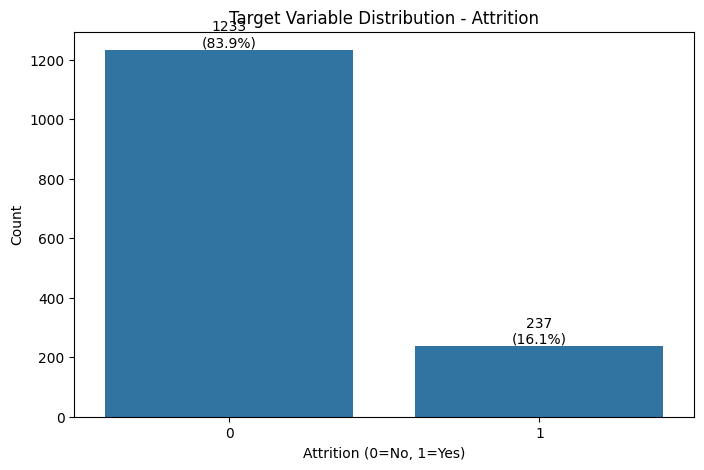

In [9]:
# Check target variable distribution
print("TARGET VARIABLE DISTRIBUTION:")
target_counts = y.value_counts()
target_percent = y.value_counts(normalize=True) * 100

print(f"Attrition = 0 (Stayed): {target_counts[0]} ({target_percent[0]:.1f}%)")
print(f"Attrition = 1 (Left):   {target_counts[1]} ({target_percent[1]:.1f}%)")

plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Target Variable Distribution - Attrition')
plt.xlabel('Attrition (0=No, 1=Yes)')
plt.ylabel('Count')
for i, count in enumerate(target_counts):
    plt.text(i, count + 10, f'{count}\n({target_percent[i]:.1f}%)', ha='center')
plt.show()

In [ ]:
# Your datasets
df_all_data = X_encoded_df.copy()
df_all_data['Attrition'] = y
df_keep_data = X_reduced.copy()  
df_keep_data['Attrition'] = y

print("📊 TARGET DISTRIBUTION:")
print(f"Class 0: {(y == 0).sum()} ({((y == 0).sum()/len(y))*100:.1f}%)")
print(f"Class 1: {(y == 1).sum()} ({((y == 1).sum()/len(y))*100:.1f}%)")

def encode_data(dataset):
    return dataset

def score(y_true, y_pred, set_name="Validation"):
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'{set_name} - Micro F1: {micro_f1:.3f}, Macro F1: {macro_f1:.3f}, Weighted F1: {weighted_f1:.3f}')
    print(f'{set_name} Classification Report:')
    print(classification_report(y_true=y_true, y_pred=y_pred))

def train_and_evaluate_model(data, model, test_size=0.2, val_size=0.25):
    """
    Proper train/validation/test split with cross-validation on training data
    """
    # 1. First split: Separate test set (20%)
    X = data.drop("Attrition", axis=1).copy()
    y = data["Attrition"].copy()
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # 2. Second split: Separate validation set from remaining data (25% of remaining = 20% of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
    )
    
    print(f"📊 DATA SPLITS:")
    print(f"  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)") 
    print(f"  Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Encode data (already done, but for consistency)
    X_train = encode_data(X_train)
    X_val = encode_data(X_val)
    X_test = encode_data(X_test)
    
    # Apply SMOTE to training data only
    print(f"🔄 Applying SMOTE to training data...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"  After SMOTE - Class 0: {(y_train_balanced == 0).sum()}, Class 1: {(y_train_balanced == 1).sum()}")
    
    # Scale the data using training data
    scaler = MinMaxScaler().fit(X_train_balanced)
    X_train_scaled = scaler.transform(X_train_balanced)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Cross-validation on training data
    print(f"🔄 Performing cross-validation...")
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X_train_scaled, y_train_balanced):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train_balanced[train_idx], y_train_balanced[val_idx]
        
        model_cv = model.__class__(**model.get_params())
        model_cv.fit(X_cv_train, y_cv_train)
        y_cv_pred = model_cv.predict(X_cv_val)
        cv_scores.append(f1_score(y_cv_val, y_cv_pred, average='weighted'))
    
    cv_f1 = np.mean(cv_scores)
    print(f"  Cross-validation F1: {cv_f1:.3f} +/- {np.std(cv_scores):.3f}")
    
    # Train final model on full training data
    print(f"🔄 Training final model...")
    model.fit(X_train_scaled, y_train_balanced)
    
    # Predictions on all sets
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_metrics = [
        f1_score(y_train_balanced, y_train_pred, average='weighted'),
        precision_score(y_train_balanced, y_train_pred, average='weighted'),
        recall_score(y_train_balanced, y_train_pred, average='weighted'),
        accuracy_score(y_train_balanced, y_train_pred),
    ]
    
    val_metrics = [
        f1_score(y_val, y_val_pred, average='weighted'),
        precision_score(y_val, y_val_pred, average='weighted'),
        recall_score(y_val, y_val_pred, average='weighted'),
        accuracy_score(y_val, y_val_pred),
    ]
    
    test_metrics = [
        f1_score(y_test, y_test_pred, average='weighted'),
        precision_score(y_test, y_test_pred, average='weighted'),
        recall_score(y_test, y_test_pred, average='weighted'),
        accuracy_score(y_test, y_test_pred),
    ]
    
    # Print results
    print(f"\n📊 FINAL RESULTS for {model.__class__.__name__}:")
    score(y_train_balanced, y_train_pred, "Training")
    score(y_val, y_val_pred, "Validation")
    score(y_test, y_test_pred, "TEST")
    
    return {
        'cv_f1': cv_f1,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model': model,
        'scaler': scaler
    }

def compare_datasets(models_dict, dataset_name, data):
    """
    Compare models on a specific dataset
    """
    print(f"\n{'='*80}")
    print(f"🔍 TESTING ON {dataset_name.upper()} DATASET")
    print(f"{'='*80}")
    
    results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n🧪 Testing {model_name}...")
        result = train_and_evaluate_model(data, model)
        results[model_name] = result
    
    return results

# Define models with proper parameters for imbalanced data
models = {
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced'),
    'NN': MLPClassifier(max_iter=2000, random_state=42),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
    'RF': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LR': LogisticRegression(C=100, penalty="l2", solver="lbfgs", random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=(y == 0).sum()/(y == 1).sum()),
    'LGBM': LGBMClassifier(random_state=42, class_weight='balanced')
}

# Compare both datasets
print("🚀 COMPREHENSIVE MODEL COMPARISON WITH PROPER TRAIN/VAL/TEST SPLITS")

all_data_results = compare_datasets(models, "ALL FEATURES", df_all_data)
keep_data_results = compare_datasets(models, "SELECTED FEATURES", df_keep_data)

# Create summary table
print(f"\n{'='*100}")
print(f"📊 FINAL COMPARISON SUMMARY")
print(f"{'='*100}")

summary_df = pd.DataFrame(
    columns=[
        "Dataset", "Model", "CV F1", "Train F1", "Val F1", "TEST F1", 
        "Test Precision", "Test Recall", "Test Accuracy"
    ]
)

row_idx = 0
for dataset_name, results in [("All Features", all_data_results), ("Selected Features", keep_data_results)]:
    for model_name, result in results.items():
        summary_df.loc[row_idx] = [
            dataset_name,
            model_name,
            f"{result['cv_f1']:.3f}",
            f"{result['train_metrics'][0]:.3f}",
            f"{result['val_metrics'][0]:.3f}",
            f"{result['test_metrics'][0]:.3f}",
            f"{result['test_metrics'][1]:.3f}",
            f"{result['test_metrics'][2]:.3f}",
            f"{result['test_metrics'][3]:.3f}"
        ]
        row_idx += 1

print(summary_df.to_string(index=False))

📊 TARGET DISTRIBUTION:
Class 0: 1233 (83.9%)
Class 1: 237 (16.1%)
🚀 COMPREHENSIVE MODEL COMPARISON WITH PROPER TRAIN/VAL/TEST SPLITS

🔍 TESTING ON ALL FEATURES DATASET

🧪 Testing KNN...
📊 DATA SPLITS:
  Training: 882 samples (60.0%)
  Validation: 294 samples (20.0%)
  Test: 294 samples (20.0%)
🔄 Applying SMOTE to training data...
  After SMOTE - Class 0: 739, Class 1: 739
🔄 Performing cross-validation...
  Cross-validation F1: 0.680 +/- 0.041
🔄 Training final model...

📊 FINAL RESULTS for KNeighborsClassifier:
Training - Micro F1: 0.802, Macro F1: 0.794, Weighted F1: 0.794
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       739
           1       0.72      1.00      0.83       739

    accuracy                           0.80      1478
   macro avg       0.86      0.80      0.79      1478
weighted avg       0.86      0.80      0.79      1478

Validation - Micro F1: 0.531, Macro F1: 0.489, Weighted F1: 0

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5864
[LightGBM] [Info] Number of data points in the train set: 1182, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6022
[LightGBM] [Info] Number of data points in the train set: 1182, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 591, number of negative: 592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5840
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 592, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5837
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Cross-validation F1: 0.923 +/- 0.008
🔄 Training final model...
[LightGBM] [Info] Number of positive: 739, number of negative: 739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7846
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

📊 FINAL RESULTS for LGBMClassifier:
Training - Micro F1: 1.000, Macro F1: 1.000, Weighted F1: 1.000
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       739

    accuracy                           1.00      1478
   macro avg       1.00      1.00      1.00      1478
weighted avg       1.00      1.00      1.00      1478

Validation - Micro F1: 0.878, Macro F1: 0

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 591, number of negative: 592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3834
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 592, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 1183, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
  Cross-validation F1: 0

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: U


📊 FINAL RESULTS for LGBMClassifier:
Training - Micro F1: 1.000, Macro F1: 1.000, Weighted F1: 1.000
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       739

    accuracy                           1.00      1478
   macro avg       1.00      1.00      1.00      1478
weighted avg       1.00      1.00      1.00      1478

Validation - Micro F1: 0.844, Macro F1: 0.636, Weighted F1: 0.823
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       247
           1       0.52      0.28      0.36        47

    accuracy                           0.84       294
   macro avg       0.70      0.61      0.64       294
weighted avg       0.82      0.84      0.82       294

TEST - Micro F1: 0.820, Macro F1: 0.554, Weighted F1: 0.788
TEST Classification Report:
              precision  